In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

In [133]:
humidity = pd.read_csv(r"C:\Users\Omkar\Desktop\deepl_retberg\humidity.csv")
temp = pd.read_csv(r"C:\Users\Omkar\Desktop\deepl_retberg\temperature.csv")
pressure = pd.read_csv(r"C:\Users\Omkar\Desktop\deepl_retberg\pressure.csv")

In [134]:
humidity_Sanfro = humidity[['datetime','San Francisco']]
temp_Sanfro = temp[['datetime','San Francisco']]
pressure_Sanfro = pressure[['datetime','San Francisco']]

In [135]:
humidity_Sanfro.head(10)

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,88.0
2,2012-10-01 14:00:00,87.0
3,2012-10-01 15:00:00,86.0
4,2012-10-01 16:00:00,85.0
5,2012-10-01 17:00:00,84.0
6,2012-10-01 18:00:00,83.0
7,2012-10-01 19:00:00,82.0
8,2012-10-01 20:00:00,81.0
9,2012-10-01 21:00:00,80.0


In [136]:
humidity_Sanfro.tail(10)

,datetime,San Francisco
45243,2017-11-29 15:00:00,NaN
45244,2017-11-29 16:00:00,NaN
45245,2017-11-29 17:00:00,NaN
45246,2017-11-29 18:00:00,NaN
45247,2017-11-29 19:00:00,NaN
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN
45252,2017-11-30 00:00:00,NaN


In [137]:
print(humidity_Sanfro.shape)
print(temp_Sanfro.shape)
print(pressure_Sanfro.shape)

(45253, 2)
(45253, 2)
(45253, 2)


In [138]:
print(humidity_Sanfro.isna().sum()['San Francisco'])
print(temp_Sanfro.isna().sum()['San Francisco'])        
print(pressure_Sanfro.isna().sum()['San Francisco'])                         #determining Na values

942
793
815


In [139]:
Tp = 10000

In [140]:
def plot_train_points(quantity='humidity',Tp=10000):
    plt.figure(figsize=(15,4))
    if quantity=='humidity':
        plt.title("Humidity of {} data points".format(Tp),fontsize=14)
        plt.plot(humidity_Sanfro['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='temperature':
        plt.title("Temperature of {} data points".format(Tp),fontsize=14)
        plt.plot(temp_Sanfro['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='pressure':
        plt.title("Pressure of {} data points".format(Tp),fontsize=14)
        plt.plot(pressure_Sanfro['San Francisco'][:Tp],c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

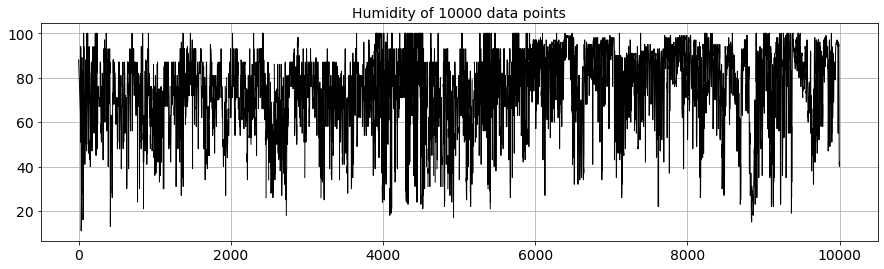

In [141]:
plot_train_points('humidity')

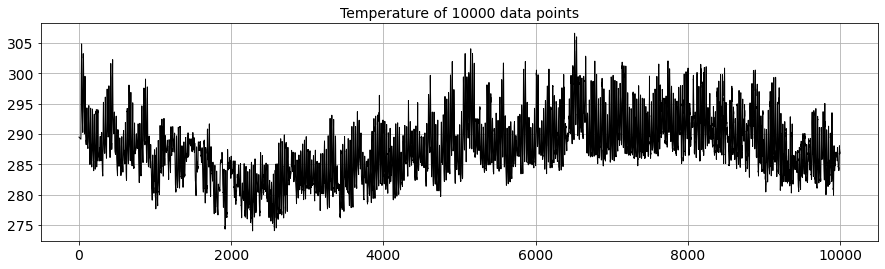

In [142]:
plot_train_points('temperature')

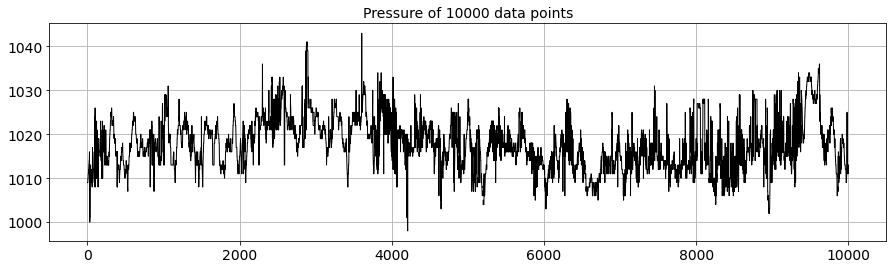

In [143]:
plot_train_points('pressure')

In [144]:
humidity_Sanfro.interpolate(inplace=True)
humidity_Sanfro.dropna(inplace=True)

temp_Sanfro.interpolate(inplace=True)
temp_Sanfro.dropna(inplace=True)

pressure_Sanfro.interpolate(inplace=True)
pressure_Sanfro.dropna(inplace=True)                                                 #fill up Na value using interpolation

In [145]:
print(humidity_Sanfro.shape)
print(temp_Sanfro.shape)
print(pressure_Sanfro.shape)

(45252, 2)
(45252, 2)
(45252, 2)


In [146]:
train = np.array(humidity_Sanfro['San Francisco'][:Tp])
test = np.array(humidity_Sanfro['San Francisco'][Tp:])

In [147]:
print("Train data:", train.shape)
print("Test data:", test.shape)

Train data: (10000,)
Test data: (35252,)


In [148]:
train=train.reshape(-1,1)
test=test.reshape(-1,1)

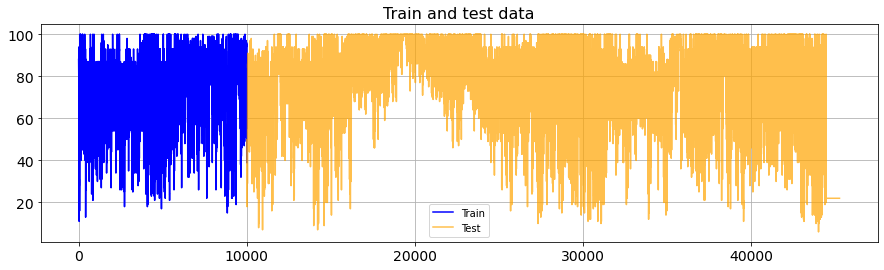

In [149]:
plt.figure(figsize=(15,4))
plt.title("Train and test data",fontsize=16)
plt.plot(np.arange(Tp),train,c='blue')
plt.plot(np.arange(Tp,45252),test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [150]:
step = 10

In [151]:
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

In [152]:
print("Train data:", train.shape)
print("Test data:", test.shape)

Train data: (10010,)
Test data: (35262,)


In [153]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [154]:
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [155]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [156]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (10000, 1, 10) ,  (10000,)
Test data shape: (35252, 1, 10) ,  (35252,)


In [157]:
def build_simple_rnn(num_units=120, embedding=10,num_dense=32,lr=0.001):
  
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [158]:
model_humidity = build_simple_rnn(num_units=120,num_dense=32,embedding=10,lr=0.0005)

C:\Users\Omkar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [159]:
model_humidity.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 120)               15720     
                                                                 
 dense_8 (Dense)             (None, 32)                3872      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,625
Trainable params: 19,625
Non-trainable params: 0
_________________________________________________________________


In [160]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [161]:
batch_size=10
num_epochs = 1000

In [162]:
model_humidity.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


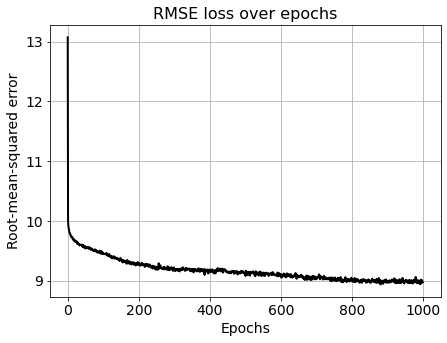

In [163]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

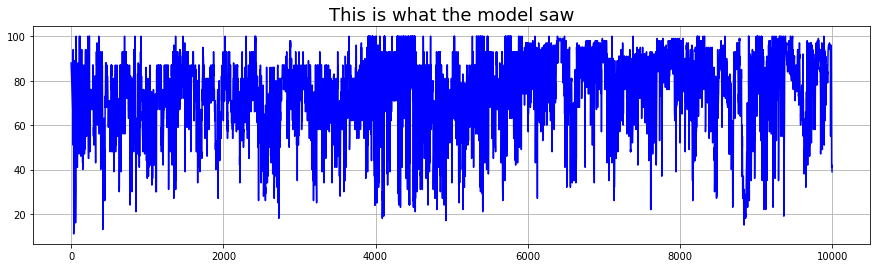

In [164]:
plt.figure(figsize=(15,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [165]:
trainPredict = model_humidity.predict(trainX)
testPredict= model_humidity.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

1102/1102 [==============================] - 3s 2ms/step


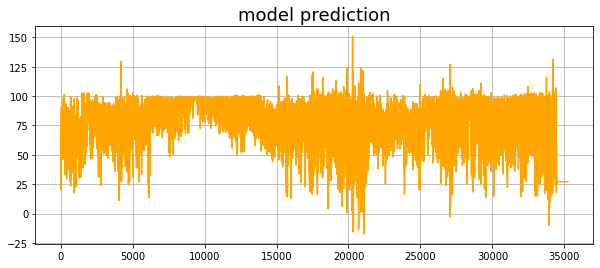

In [166]:
plt.figure(figsize=(10,4))
plt.title("model prediction",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

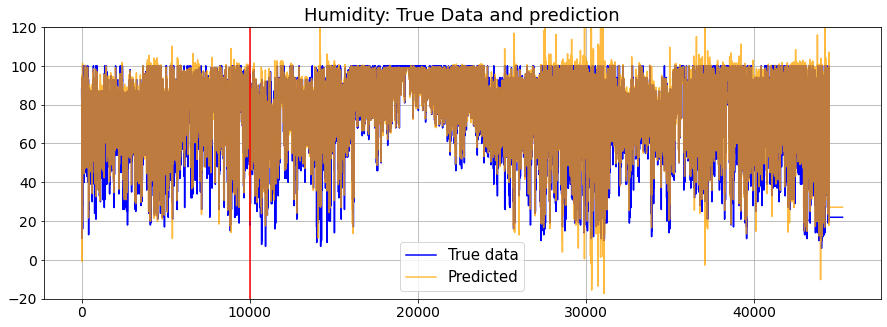

In [177]:
index = humidity_Sanfro.index.values

plt.figure(figsize=(15,5))
plt.title("Humidity: True Data and prediction",fontsize=18)
plt.plot(index,humidity_Sanfro['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()

In [178]:
train = np.array(temp_Sanfro['San Francisco'][:Tp])
test = np.array(temp_Sanfro['San Francisco'][Tp:])

train=train.reshape(-1,1)
test=test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [179]:
model_temp = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 2000

model_temp.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done
Epoch number 1050 done
Epoch number 1100 done
Epoch number 1150 done
Epoch number 1200 done
Epoch number 1250 done
Epoch number 1300 done
Epoch number 1350 done
Epoch number 1400 done
Epoch number 1450 done
Epoch number 1500 done
Epoch number 1550 done
Epoch number 1600 done
Epoch number 1650 done
Epoch number 1700 done
Epoch number 1750 done
Epoch number 1800 done
Epoch number 1850 done
Epoch number 1900 done
Epoch number 1950 done
Epoch number 2000 done


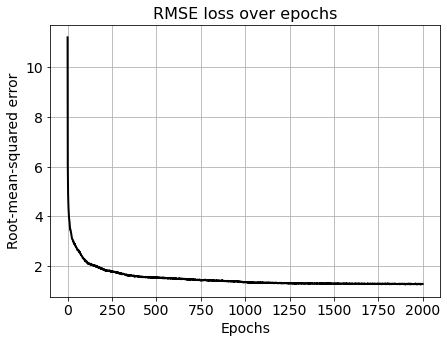

In [180]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_temp.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [181]:
trainPredict = model_temp.predict(trainX)
testPredict= model_temp.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

1102/1102 [==============================] - 1s 1ms/step


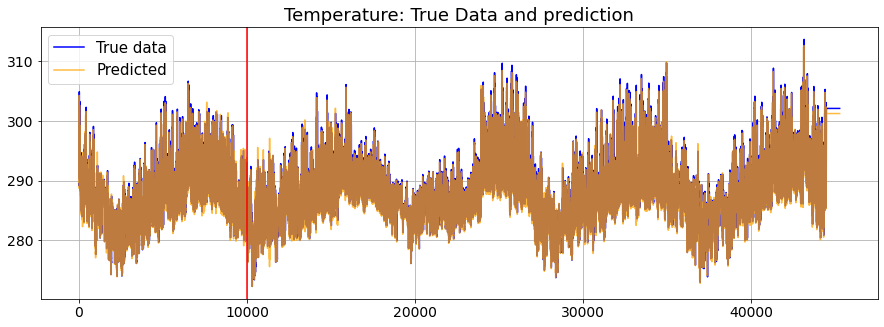

In [184]:
index = temp_Sanfro.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: True Data and prediction",fontsize=18)
plt.plot(index,temp_Sanfro['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [185]:
train = np.array(pressure_Sanfro['San Francisco'][:Tp])
test = np.array(pressure_Sanfro['San Francisco'][Tp:])

train=train.reshape(-1,1)
test=test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [186]:
model_pressure = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 500

model_pressure.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done


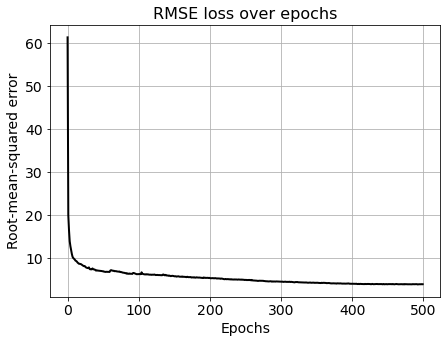

In [187]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_pressure.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [188]:
trainPredict = model_pressure.predict(trainX)
testPredict= model_pressure.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

1102/1102 [==============================] - 1s 1ms/step


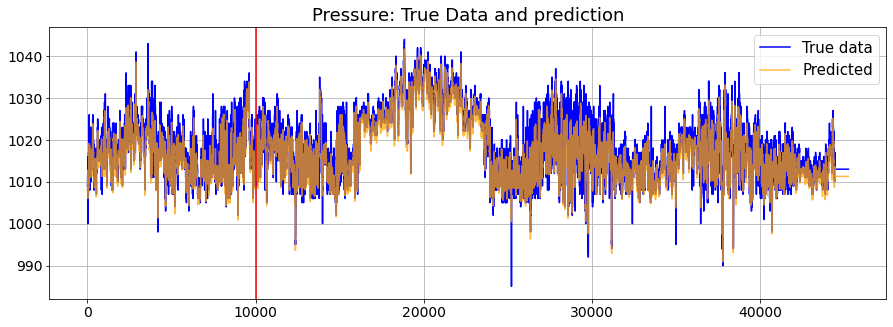

In [189]:
index = pressure_Sanfro.index.values

plt.figure(figsize=(15,5))
plt.title("Pressure: True Data and prediction",fontsize=18)
plt.plot(index,pressure_Sanfro['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()